

##### 数据集信息：
该数据集与葡萄牙某银行机构的电话营销活动有关。营销活动基于电话呼叫。通常，需要多次联系同一客户，以确定客户是否会订阅产品（银行定期存款）。

##### 银行客户数据：
- age：年龄（数值型）
- job：工作类型（类别型：'admin.'、'blue-collar'、'entrepreneur'、'housemaid'、'management'、'retired'、self-employed'、'services'、'student'、'technician'、'unemployed'、'unknown'）
- marital：婚姻状况（类别型：'divorced'、'married'、'single'、'unknown'；注意：'divorced' 包括离婚和丧偶）
- education：教育程度（类别型：'basic.4y'、'basic.6y'、'basic.9y'、'high.school'、'illiterate'、'professional.course'、'university.degree'、'unknown'）
- default：是否有违约信用（类别型：'no'、'yes'、'unknown'）
- balance：年均余额（数值型）
- housing：是否有住房贷款（类别型：'no'、'yes'、'unknown'）
- loan：是否有个人贷款（类别型：'no'、'yes'、'unknown'）

##### 与当前活动的最后一次联系相关：
- contact：联系通信类型（类别型：'cellular'、'telephone'）
- month：最后一次联系的月份（类别型：'jan'、'feb'、'mar'、...、'nov'、'dec'）
- day：最后一次联系的日期（数值型：1-31）
- duration：最后一次联系的持续时间（秒）（数值型）。重要提示：此属性对输出目标有很大影响（例如，如果 duration=0 则 y='no'）。然而，在进行呼叫之前不知道持续时间。此外，呼叫结束后显然知道 y。因此，如果目的是建立一个现实的预测模型，则此输入应仅用于基准目的并应被丢弃。

##### 其他属性：
- campaign：在此活动期间为此客户执行的联系次数（数值型，包括最后一次联系）
- pdays：自上次联系客户以来经过的天数（数值型；-1表示客户之前未被联系）
- previous：在此活动之前为此客户执行的联系次数（数值型）
- poutcome：之前营销活动的结果（类别型：'failure'、'nonexistent'、'success'）

##### 输出变量（目标变量）：
- y：客户是否订阅了定期存款（二元：'yes'、'no'）

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')
PIC_PATH = './pics/bankMarketing'
RANDOM_SEED = 42

In [2]:
data_path = './data'
data = pd.read_csv(os.path.join(data_path, 'bank+marketing', 'bank', 'bank-full.csv'), sep=';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [22]:
data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [37]:
Bank_Marketing_info = pd.DataFrame(data.dtypes, columns=['type']).reset_index()
Bank_Marketing_info["type"][Bank_Marketing_info["type"] == 'object'] = 'discrete'
Bank_Marketing_info["type"][(Bank_Marketing_info["type"] == 'int64') | (Bank_Marketing_info["type"] == 'float64')] = 'continuous'
Bank_Marketing_info.loc[len(Bank_Marketing_info.index)] = ['LABEL_POS', -1]
Bank_Marketing_info.to_csv('./data/bank-marketing.info', header=False, index=False)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
data.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

# EDA

In [17]:
data['y'].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

正例太少，需要过采样

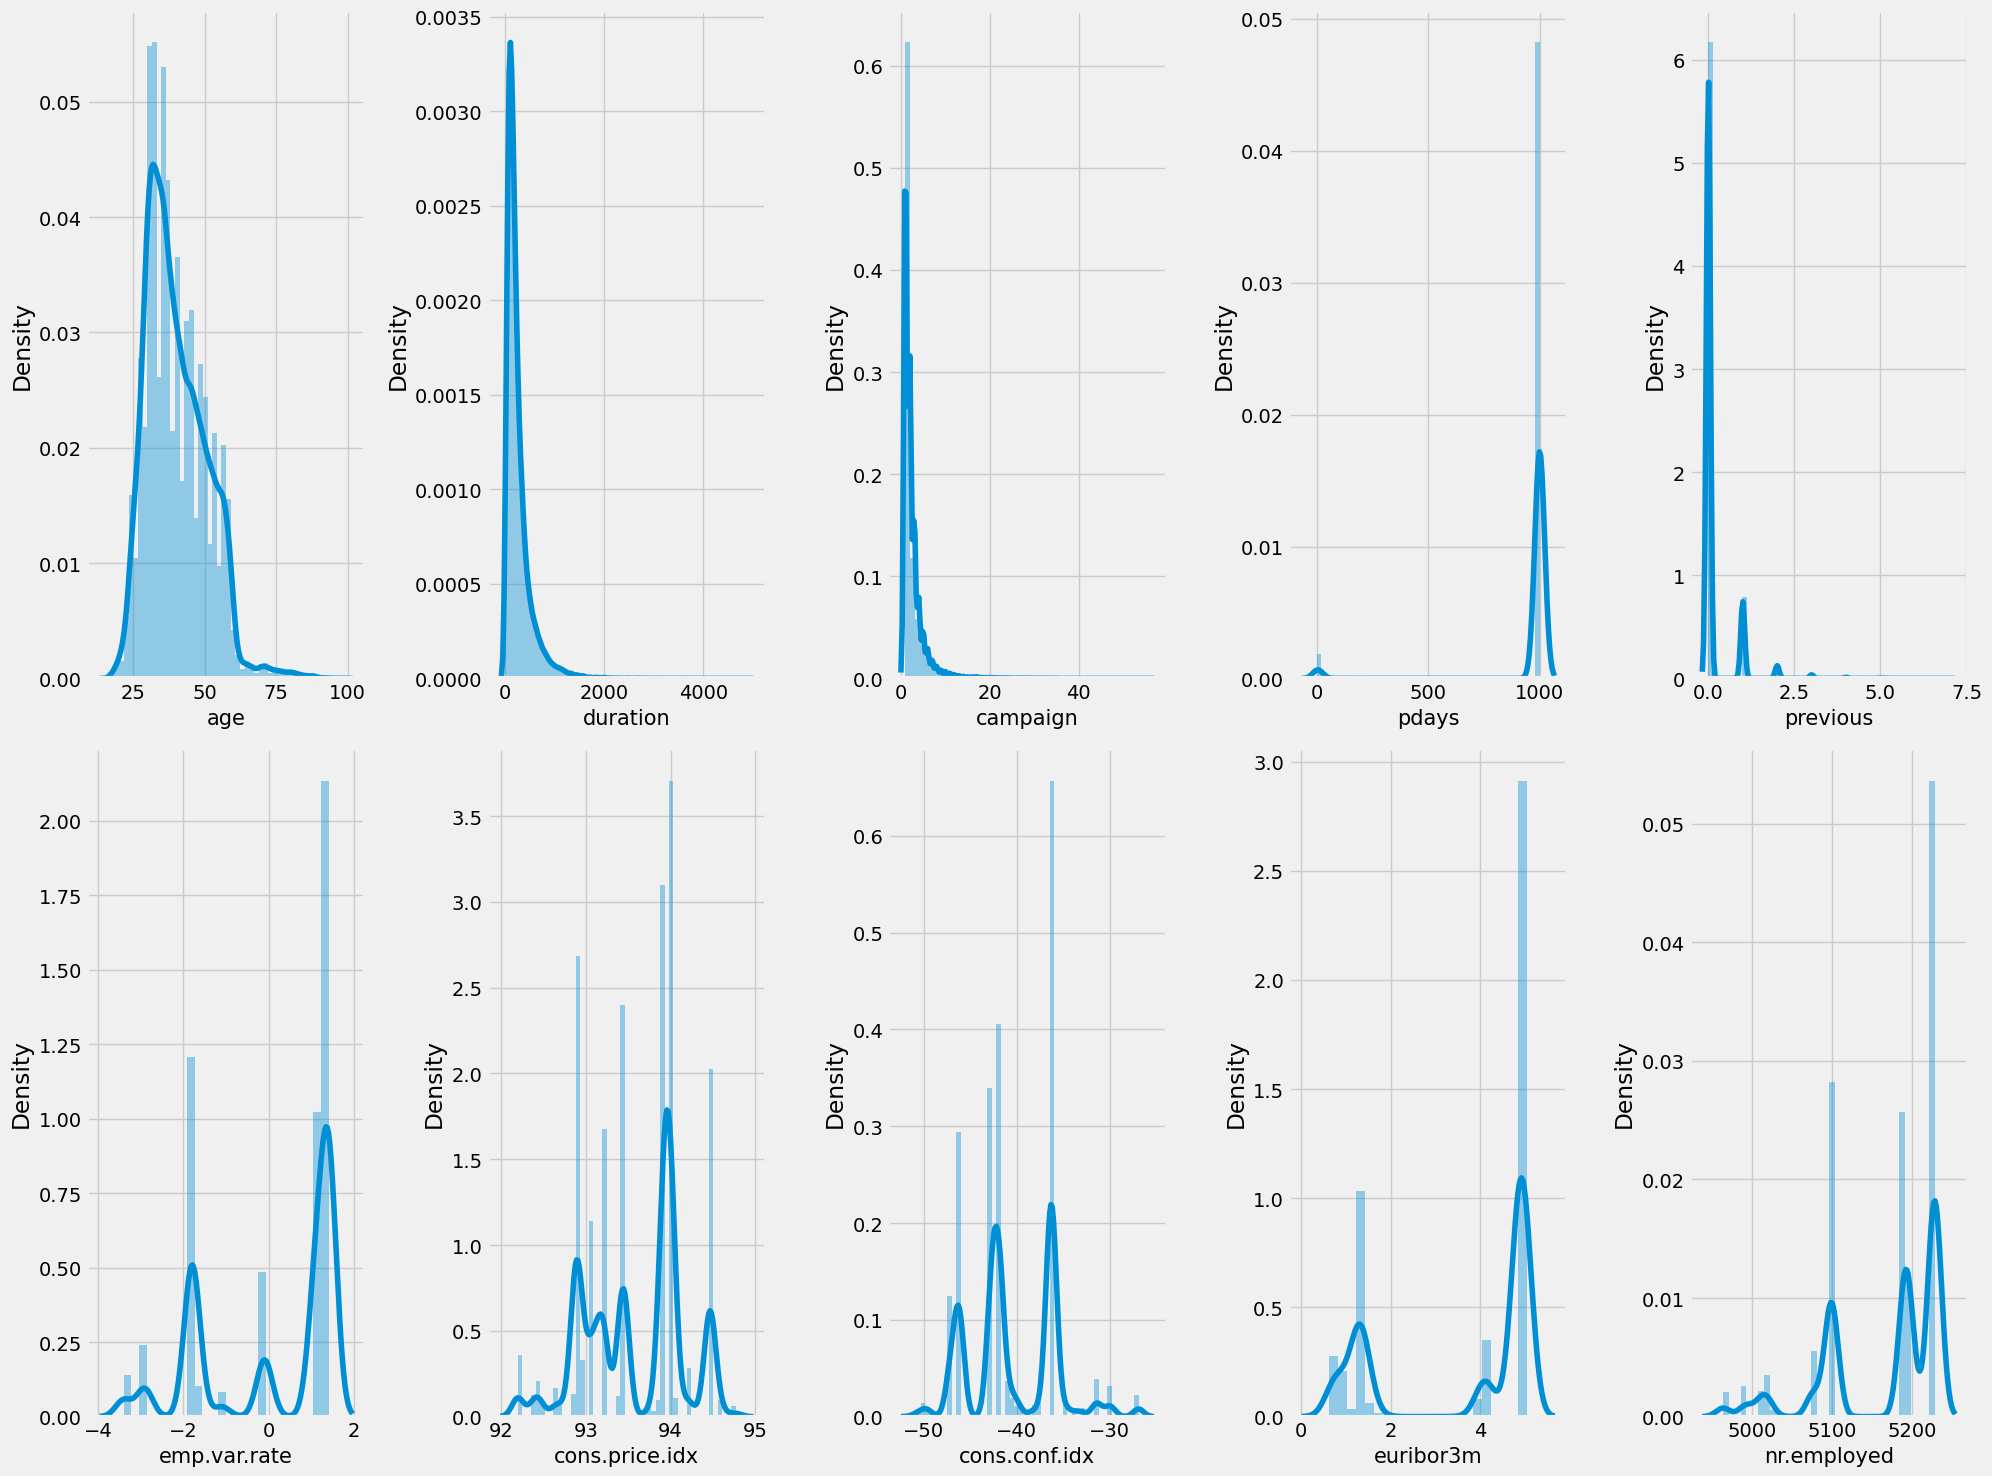

In [28]:
plt.figure(figsize = (20, 15))
numeric_var = data.dtypes[(data.dtypes == 'int64') | (data.dtypes == 'float64')].index.tolist()
for i, column in enumerate(data[numeric_var]):
    ax = plt.subplot(2, 5, i + 1)
    sns.distplot(data[column])
    plt.xlabel(column, fontsize = 15)

plt.tight_layout()
plt.show()

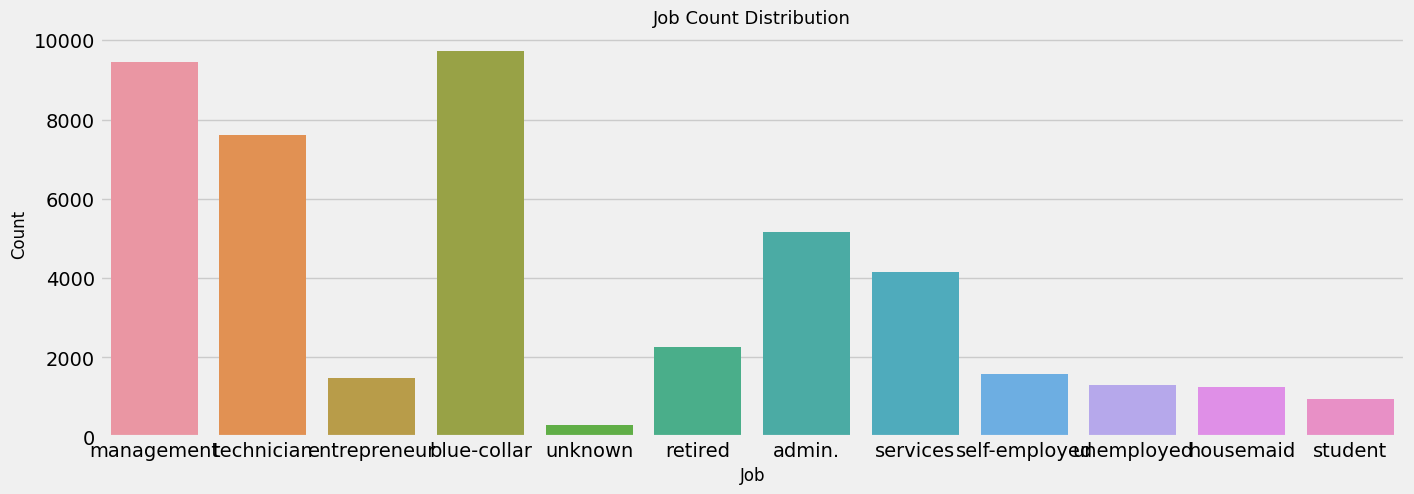

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
sns.countplot(x = "job", data = data)
ax.set_xlabel('Job', fontsize = 12)
ax.set_ylabel('Count', fontsize = 12)
ax.set_title("Job Count Distribution", fontsize = 13)
plt.savefig(os.path.join(PIC_PATH, 'EDA/Job_count_distribution.jpg'))

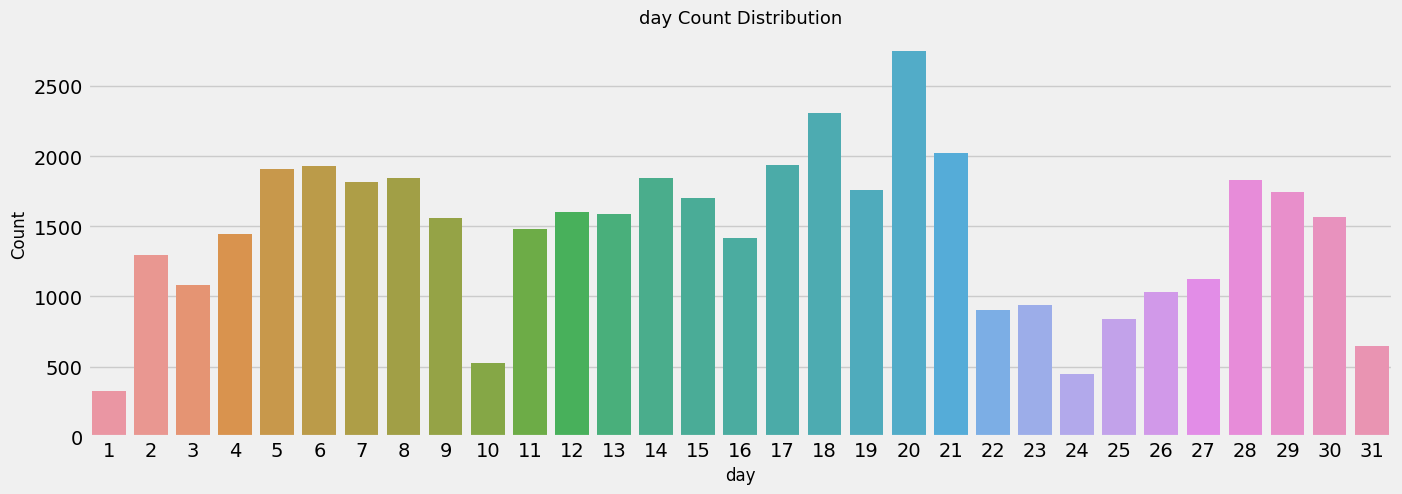

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
sns.countplot(x = "day", data = data)
ax.set_xlabel('day', fontsize = 12)
ax.set_ylabel('Count', fontsize = 12)
ax.set_title("day Count Distribution", fontsize = 13)
plt.savefig(os.path.join(PIC_PATH, 'EDA/Day_count_distribution.jpg'))

Text(0, 0.5, 'Count')

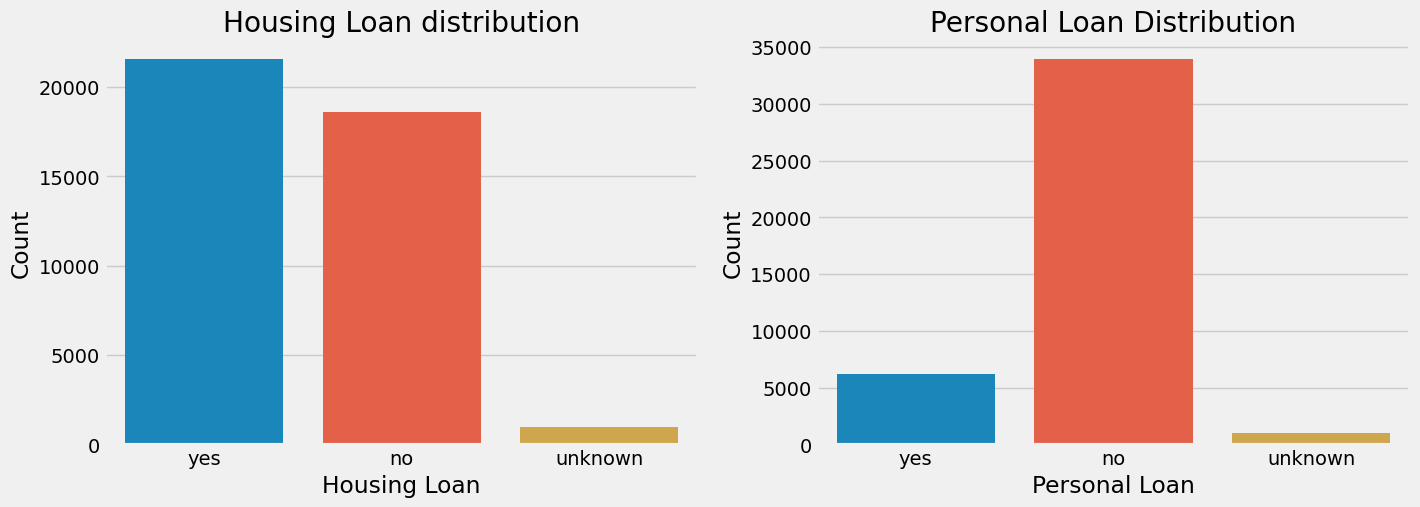

In [31]:
# Housing loan data distribution
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
sns.countplot(x = "housing", data = data, ax = ax1, order = ['yes', 'no', 'unknown'])
ax1.set_title("Housing Loan distribution")
ax1.set_xlabel("Housing Loan")
ax1.set_ylabel("Count")

# Personal loan data distribution
sns.countplot(x = "loan", data = data, ax = ax2, order = ['yes', 'no', 'unknown'])
ax2.set_title("Personal Loan Distribution")
ax2.set_xlabel("Personal Loan")
ax2.set_ylabel("Count")

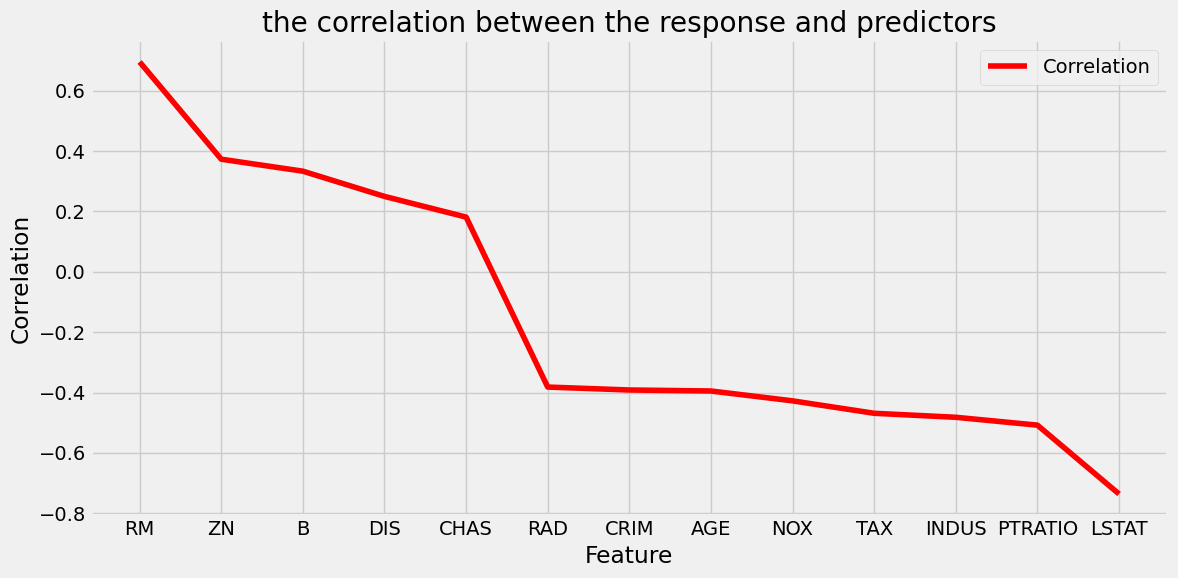

In [38]:
plt.figure(figsize=(12,6))
plt.plot(data.corr()["MEDV"].sort_values(ascending=False)[1:],label="Correlation",color="red")
plt.ylabel("Correlation")
plt.xlabel("Feature")
plt.title("the correlation between the response and predictors")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

RM相关性最高

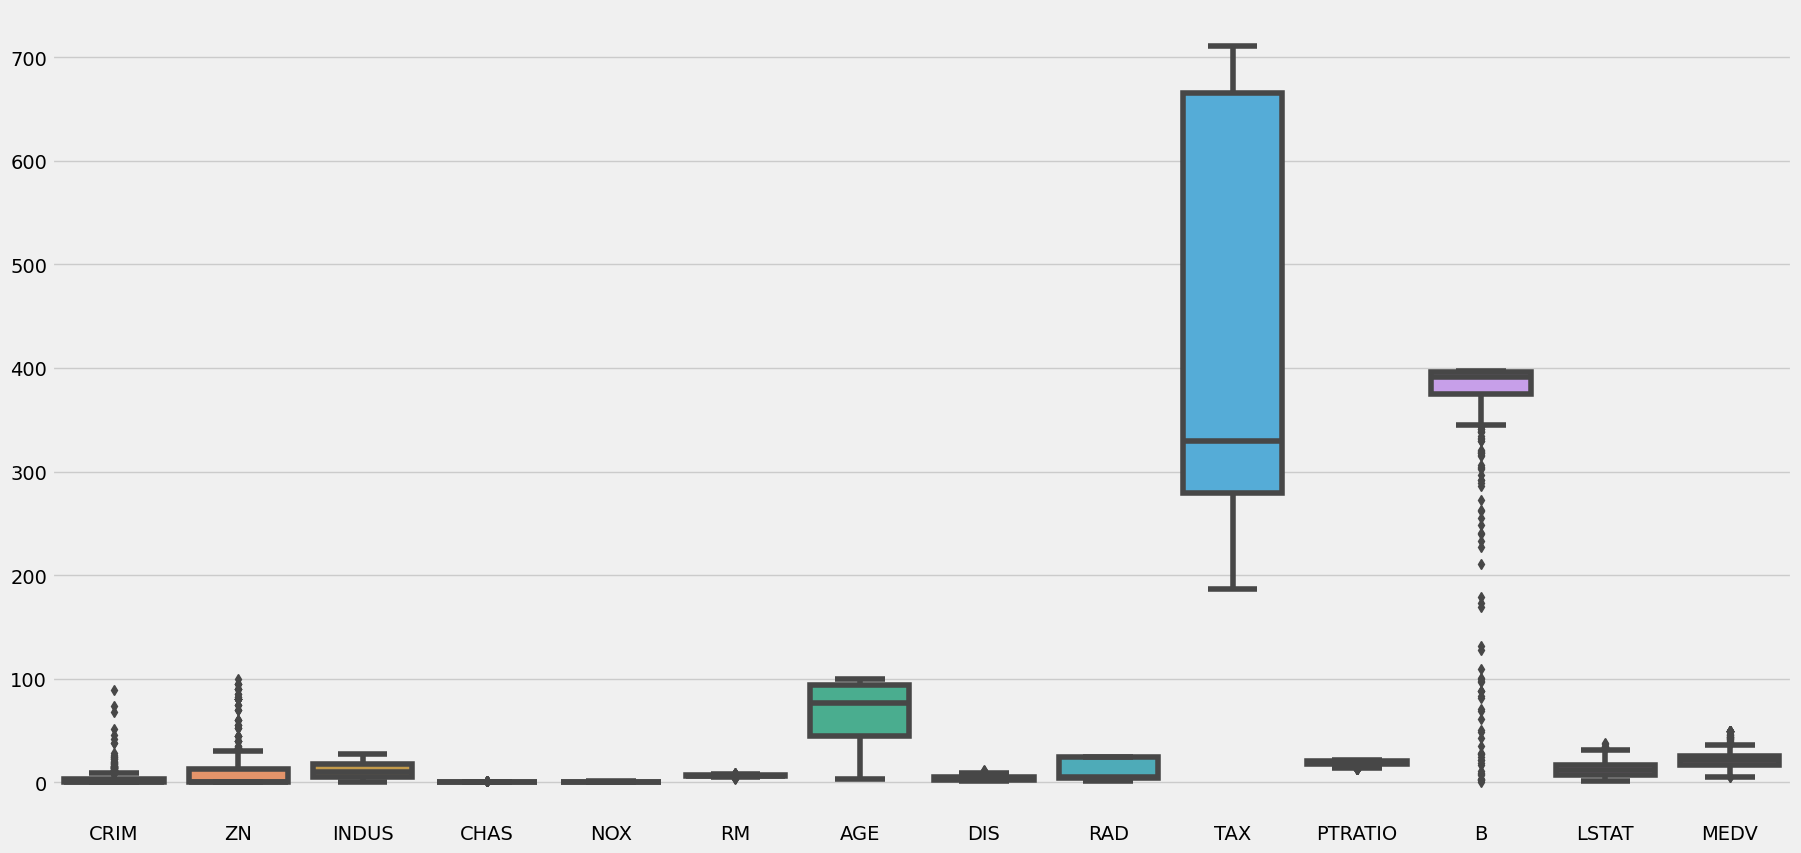

In [25]:
plt.figure(figsize=(20, 10))
sns.boxplot(data, width = 0.8)
plt.show()

需要标准化

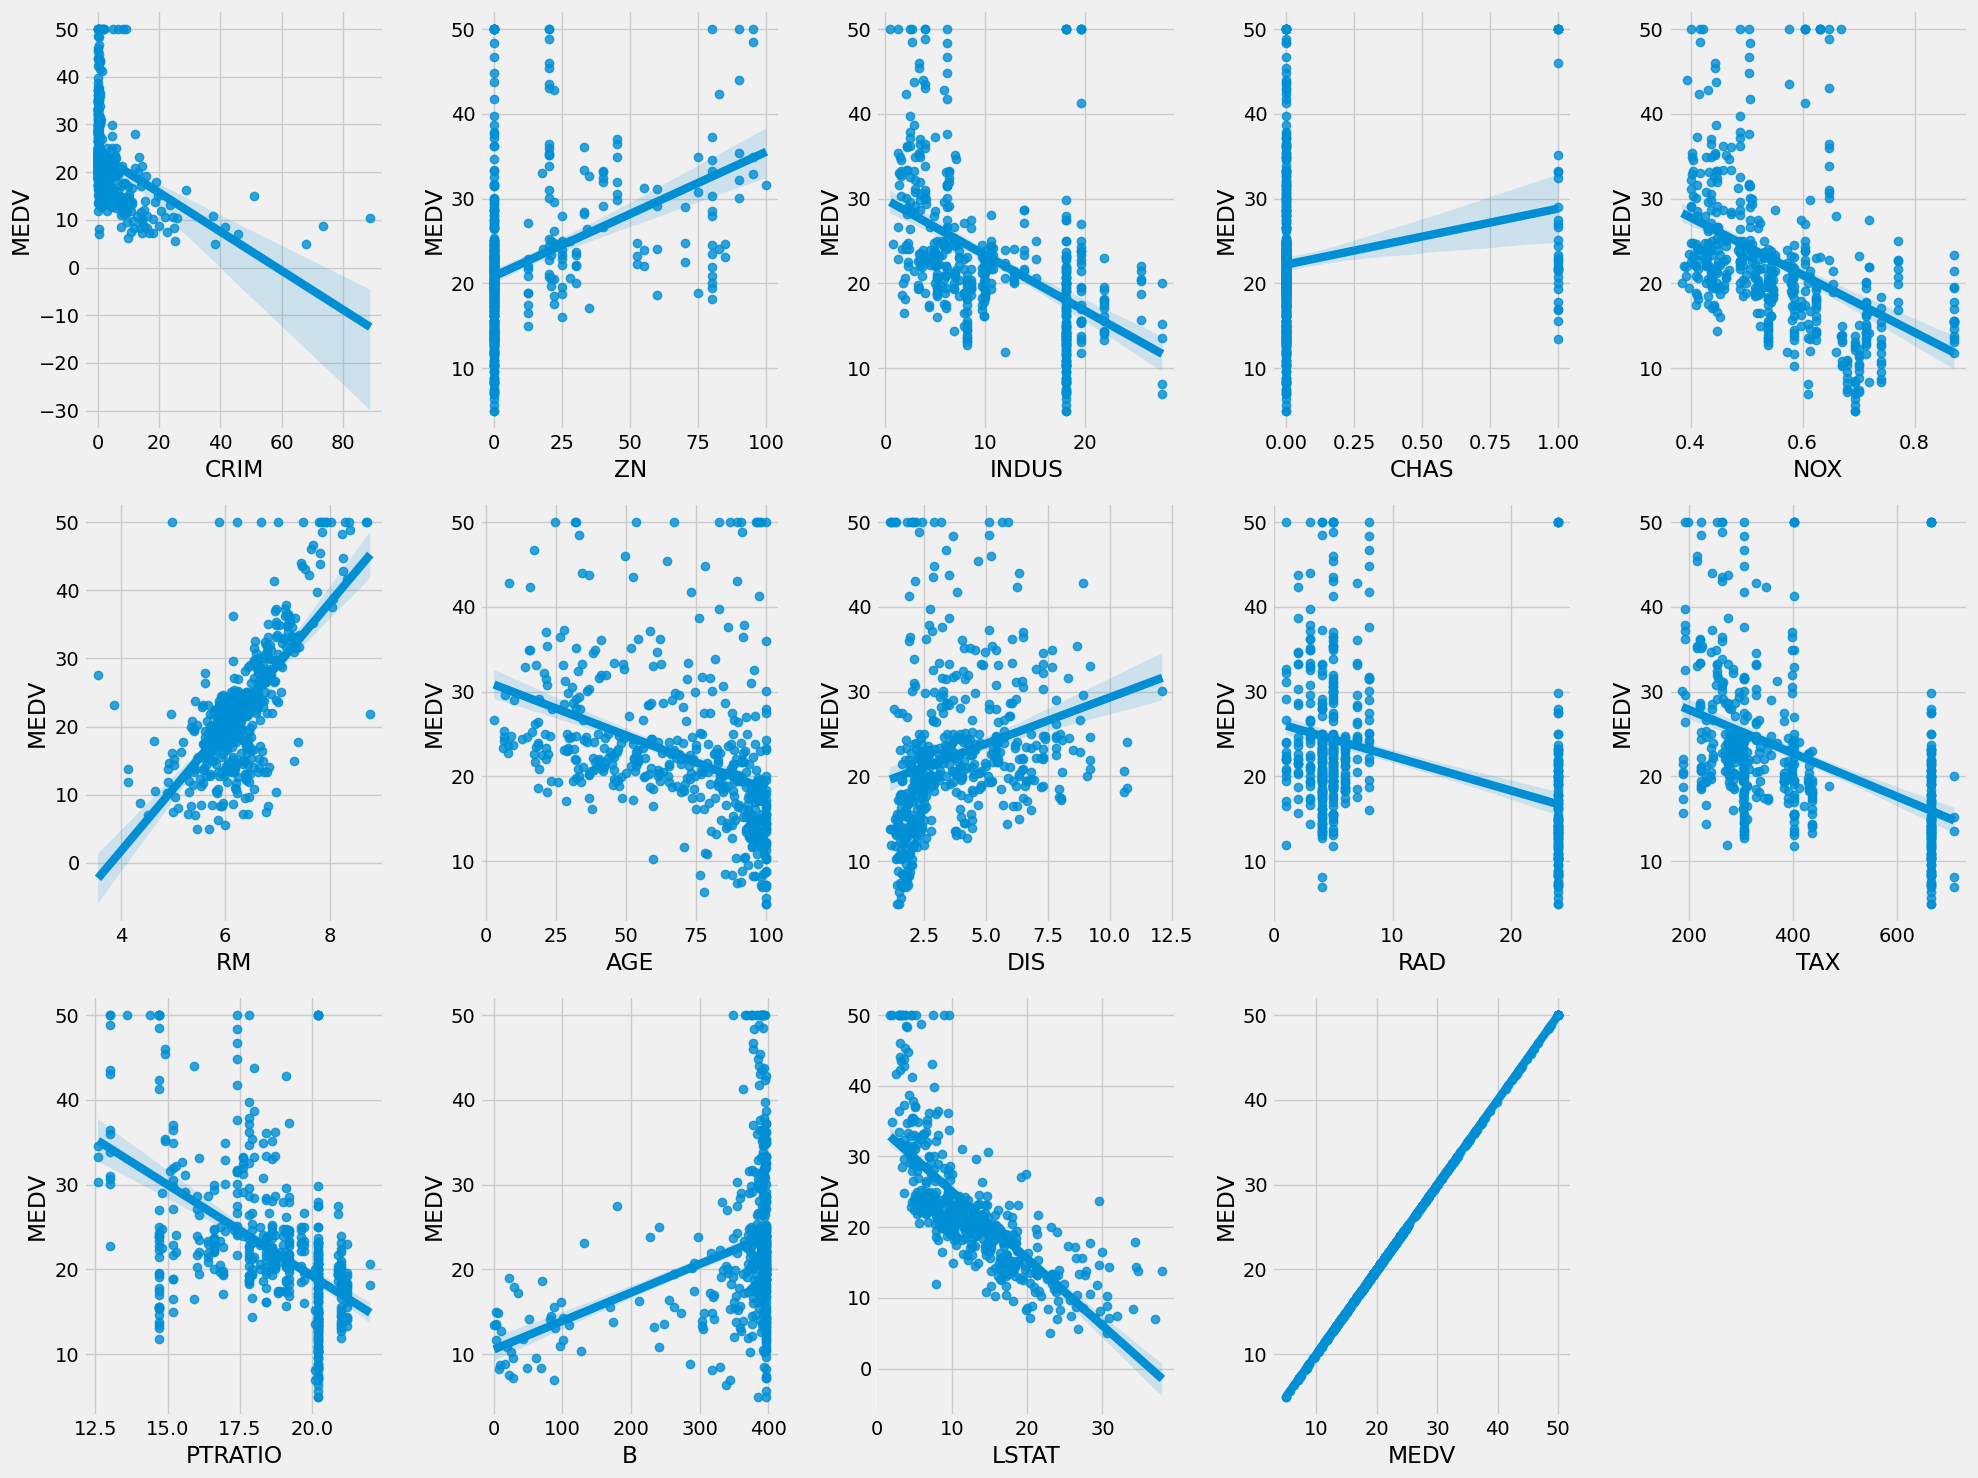

In [39]:
plt.figure(figsize = (20, 15))

for i, column in enumerate(data):
    ax = plt.subplot(3, 5, i + 1)
    sns.regplot(x=data[column], y=data['MEDV'])

plt.tight_layout()
plt.show()

# Data preprocessing

### 客户特征

In [4]:
bank_client = data.loc[: , ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',	'loan']]
bank_client.head()

,age,job,marital,education,default,balance,housing,loan
0,58,management,married,tertiary,no,2143,yes,no
1,44,technician,single,secondary,no,29,yes,no
2,33,entrepreneur,married,secondary,no,2,yes,yes
3,47,blue-collar,married,unknown,no,1506,yes,no
4,33,unknown,single,unknown,no,1,no,no


In [5]:
from sklearn.preprocessing import LabelEncoder
labelencoder_X = LabelEncoder()
bank_client['job']      = labelencoder_X.fit_transform(bank_client['job']) 
bank_client['marital']  = labelencoder_X.fit_transform(bank_client['marital']) 
bank_client['education']= labelencoder_X.fit_transform(bank_client['education']) 
bank_client['default']  = labelencoder_X.fit_transform(bank_client['default']) 
bank_client['housing']  = labelencoder_X.fit_transform(bank_client['housing']) 
bank_client['loan']     = labelencoder_X.fit_transform(bank_client['loan']) 

In [20]:
bank_client.head()

,age,job,marital,education,default,balance,housing,loan
0,58,4,1,2,0,2143,1,0
1,44,9,2,1,0,29,1,0
2,33,2,1,1,0,2,1,1
3,47,1,1,3,0,1506,1,0
4,33,11,2,3,0,1,0,0


### 上次联系相关特征

In [6]:
bank_related = data.loc[:, ['contact', 'month', 'day', 'duration']]
bank_related.head()

,contact,month,day,duration
0,unknown,may,5,261
1,unknown,may,5,151
2,unknown,may,5,76
3,unknown,may,5,92
4,unknown,may,5,198


In [7]:
print("Kind of Contact: \n", bank_related['contact'].unique())
print("\nWhich monthis this campaing work: \n", bank_related['month'].unique())
print("\nWhich days of week this campaing work: \n", bank_related['day'].unique())

Kind of Contact: 
 ['unknown' 'cellular' 'telephone']

Which monthis this campaing work: 
 ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

Which days of week this campaing work: 
 [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]


In [7]:
from sklearn.preprocessing import LabelEncoder
labelencoder_X = LabelEncoder()
bank_related['contact'] = labelencoder_X.fit_transform(bank_related['contact']) 
bank_related['month'] = labelencoder_X.fit_transform(bank_related['month']) 
bank_related.head()

,contact,month,day,duration
0,2,8,5,261
1,2,8,5,151
2,2,8,5,76
3,2,8,5,92
4,2,8,5,198


### 其他特征

In [8]:
bank_o = data.loc[: , ['campaign', 'pdays','previous', 'poutcome']]
bank_o.head()

,campaign,pdays,previous,poutcome
0,1,-1,0,unknown
1,1,-1,0,unknown
2,1,-1,0,unknown
3,1,-1,0,unknown
4,1,-1,0,unknown


In [29]:
bank_o['poutcome'].unique()

array(['unknown', 'failure', 'other', 'success'], dtype=object)

In [9]:
bank_o['poutcome'].replace(['unknown', 'failure', 'success', 'other'], [0, 1,2,3], inplace  = True)

## 汇总

In [10]:
bank_final= pd.concat([bank_client, bank_related, bank_o], axis = 1)
bank_final.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,day,duration,campaign,pdays,previous,poutcome
0,58,4,1,2,0,2143,1,0,2,8,5,261,1,-1,0,0
1,44,9,2,1,0,29,1,0,2,8,5,151,1,-1,0,0
2,33,2,1,1,0,2,1,1,2,8,5,76,1,-1,0,0
3,47,1,1,3,0,1506,1,0,2,8,5,92,1,-1,0,0
4,33,11,2,3,0,1,0,0,2,8,5,198,1,-1,0,0


In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

def preprocess(data):
    X = data.drop("y", axis = 1)
    y = data["y"].replace(['no', 'yes'], [0, 1])
    le = LabelEncoder()
    categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                            'contact', 'month', 'poutcome']
    for feature in categorical_features:
        X[feature] = le.fit_transform(X[feature])
    return X.values, y.values

X, y = preprocess(data)

In [4]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_SEED)

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
def print_metrics(y_test, y_pred, y_pred_prob):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    cm = confusion_matrix(y_test, y_pred)
    print(f"accuracy: {accuracy*100:.2f}%")
    print(f"precision: {precision*100:.2f}%")
    print(f"recall: {recall*100:.2f}%")
    print(f"f1: {f1*100:.2f}%")
    print(f"auc: {auc*100:.2f}%")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join(PIC_PATH, 'result', 'xgb conf_mat.jpg'))

# XGBoost

accuracy: 88.61%
precision: 51.01%
recall: 66.91%
f1: 57.89%
auc: 91.68%


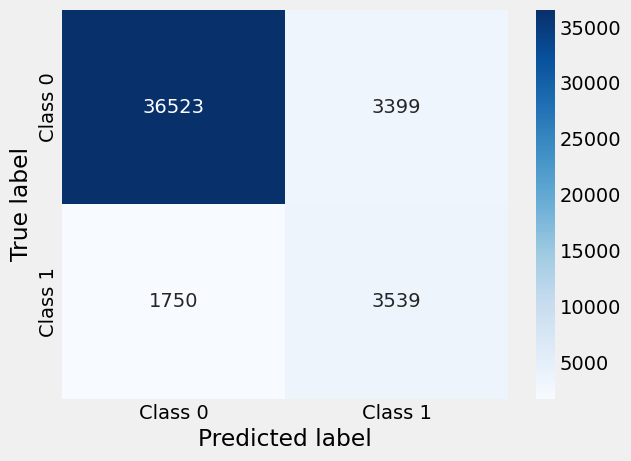

In [17]:
import xgboost
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

xgb = xgboost.XGBClassifier(random_state=RANDOM_SEED)
# xgb.fit(X_train, y_train)
# y_pred = xgb.predict(X_test)
# y_pred_prob = xgb.predict_proba(X_test)[:, 1]


smote = SMOTE(sampling_strategy='auto', random_state=RANDOM_SEED)
pipeline = ImbPipeline(steps=[
    ('smote', smote),
    ('classifier', xgb)
])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)

print_metrics(y, y_pred, y_pred_prob)

# RandomForest

## 调库

accuracy: 88.07%
precision: 49.28%
recall: 67.33%
f1: 56.91%
auc: 91.14%


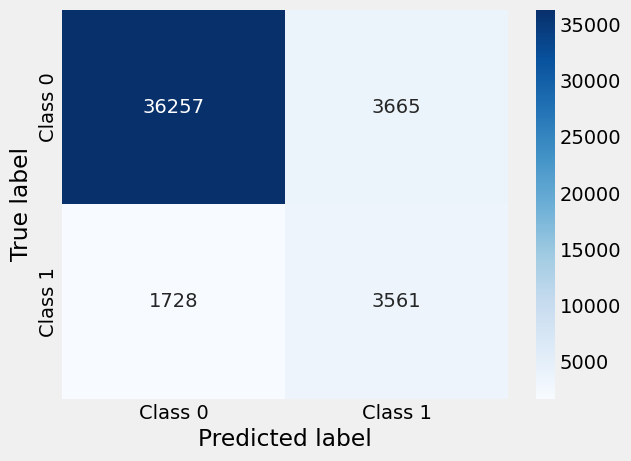

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

random_state = 42
rf_sklearn = RandomForestClassifier(n_estimators=50, 
                            max_depth=None, 
                            min_samples_split=20,
                            random_state=random_state, 
                            max_features='sqrt',
                            oob_score=True)
smote = SMOTE(sampling_strategy='auto', random_state=RANDOM_SEED)
pipeline = ImbPipeline(steps=[
    ('smote', smote),
    ('classifier', rf_sklearn)
])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)

print_metrics(y, y_pred, y_pred_prob)

## 自实现

In [21]:
from RandomForest import RandomForest
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_SEED)

random_state = 42
rf_custom = RandomForest(n_estimators=50, 
                            max_depth=10, 
                            min_samples_split=20,
                            mode="classification", 
                            random_state=random_state, 
                            max_features='sqrt',
                            oob_score=False,
                            n_jobs=1
                            )
smote = SMOTE(sampling_strategy='auto', random_state=RANDOM_SEED)
X_train, y_train = smote.fit_resample(X_train, y_train)
# pipeline = ImbPipeline(steps=[
#     ('smote', smote),
#     ('classifier', rf_custom)
# ])
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')[:, 1]

rf_custom.fit(X_train, y_train)
y_pred_prob = rf_custom.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

print_metrics(y, y_pred, y_pred_prob)



# rf_custom.fit(X_train, y_train)
# y_pred = rf_custom.predict(X_test)

ValueError: Found input variables with inconsistent numbers of samples: [45211, 9043]

In [22]:
y_pred_prob

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)